In [1]:
import os

import pandas as pd
import yaml

from src.dataPipeline import DataPipeline

os.chdir('..')

In [2]:

with open('src/params.yaml', 'r', encoding='utf-8') as file:
    params = yaml.safe_load(file)
    
columnsToDrop = params['columns_to_drop_all']

In [3]:
from sklearn.cluster import KMeans
import pgeocode
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split

dp = DataPipeline()
dp.readCsv('data/immo_data_202208_v2.csv')


df = dp.data
feature_dummies =  df['type_unified'].str.get_dummies(sep='\t')
df = pd.concat([df, feature_dummies], axis=1)
df = df.drop(columns=['type_unified'])

dp.data = df

dp.dropColumns(columnsToDrop)

df = dp.data


for column in df.columns:
    if column not in ['Availability', 'type', 'provider', 'type_unified', 'detailed_description']:
        try:
            df[column] = df[column].astype(float)
        except:
            print(f'Error in column: {column}')
            break

#df['Availability'] = df['Availability'].apply(
#    lambda x: 'Future' if len(str(x).split('.')) > 1 else x
#)


nomi = pgeocode.Nominatim('ch')
mask = df['lat'].isna()  # Check for missing latitude values
missing_postal_codes = df.loc[mask, 'plz_parsed'].reset_index()
postal_list = missing_postal_codes['plz_parsed'].values.astype("str").tolist()
location_data = nomi.query_postal_code(postal_list)
df.loc[mask, 'lat'] = location_data['latitude'].values
df.loc[mask, 'lon'] = location_data['longitude'].values



train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

kmeans = KMeans(n_clusters=50, random_state=42)
train_df['region_group'] = kmeans.fit_predict(train_df[['lon', 'lat']])

test_df['region_group'] = kmeans.predict(test_df[['lon', 'lat']])

train_df = pd.get_dummies(train_df, columns=['region_group'])
test_df = pd.get_dummies(test_df, columns=['region_group'])

train_df = train_df.drop(columns=['lon', 'lat', 'plz_parsed'])
test_df = test_df.drop(columns=['lon', 'lat', 'plz_parsed'])

dp.data = train_df

dp.encodeCategoricalFeatures()
dp.standardize()

# Assign the processed train and test data back
train_df = dp.data
dp.data = test_df
dp.encodeCategoricalFeatures()
dp.standardize()

test_df = dp.data

# Filter out invalid prices
train_df = train_df.dropna(subset=['price_cleaned'])
train_df = train_df[train_df['price_cleaned'] > 100000]

C:\FHNW_Programmiersachen\5_Sem\immo_challenge\src\dataPipeline.py:45: DtypeWarning: Columns (3,4,5,6,11,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,45,46,47,49,50,107,110,114,115,116,119,120,121,124,125,126,128,131,132) have mixed types. Specify dtype option on import or set low_memory=False.
  self.data = pd.read_csv(filePath)


ValueError: Input X contains NaN.
KMeans does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [27]:
'''
dp.readCsv('data/test_data-Kaggle-v0.11.csv')


df_kaggle = dp.data
feature_dummies =  df_kaggle['type_unified'].str.get_dummies(sep='\t')
df_kaggle = pd.concat([df_kaggle, feature_dummies], axis=1)
df_kaggle = df_kaggle.drop(columns=['type_unified'])

dp.data = df_kaggle


dp.dropColumns(columnsToDrop)

df_kaggle = dp.data


for column in df_kaggle.columns:
    if column not in ['Availability', 'type', 'provider', 'type_unified', 'detailed_description']:
        try:
            df_kaggle[column] = df_kaggle[column].astype(float)
        except:
            print(f'Error in column: {column}')
            break

#df_kaggle['Availability'] = df_kaggle['Availability'].apply(
#    lambda x: 'Future' if len(str(x).split('.')) > 1 else x
#)

nomi = pgeocode.Nominatim('ch')
mask = df_kaggle['lat'].isna()  # Check for missing latitude values
missing_postal_codes = df_kaggle.loc[mask, 'plz_parsed'].reset_index()
postal_list = missing_postal_codes['plz_parsed'].values.astype("str").tolist()
location_data = nomi.query_postal_code(postal_list)
df_kaggle.loc[mask, 'lat'] = location_data['latitude'].values
df_kaggle.loc[mask, 'lon'] = location_data['longitude'].values

columns_to_drop = ['price_cleaned', 'type', 'type_unified', 'detailed_description']
columns_to_impute = [col for col in df_kaggle.columns if col not in columns_to_drop]
df_kaggle[columns_to_impute] = imputer.fit_transform(df_kaggle[columns_to_impute])

df_kaggle['region_group'] = kmeans.predict(df_kaggle[['lon', 'lat']])
df_kaggle = pd.get_dummies(df_kaggle, columns=['region_group'])
df_kaggle = df_kaggle.drop(columns=['lon', 'lat', 'plz_parsed'])


dp.data = df_kaggle

dp.encodeCategoricalFeatures()
dp.standardize()
df_kaggle = dp.data
'''

C:\FHNW_Programmiersachen\5_Sem\immo_challenge\src\dataPipeline.py:44: DtypeWarning: Columns (3,4,5,6,11,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,45,46,48,49,104,111,112,115,116,117,120,121,122,124,127,128,130,131) have mixed types. Specify dtype option on import or set low_memory=False.
  self.data = pd.read_csv(filePath)


In [157]:
df_kaggle

,ForestDensityL,ForestDensityM,ForestDensityS,gde_empty_apartments,gde_foreigners_percentage,gde_new_homes_per_1000,gde_population,gde_tax,Space extracted,Plot_area_unified,...,region_group_40,region_group_41,region_group_42,region_group_43,region_group_44,region_group_45,region_group_46,region_group_47,region_group_48,region_group_49
0,-0.119642,-0.134134,-0.094526,-0.601894,0.705140,-0.086738,-0.105885,0.054290,0.443876,-0.080628,...,-0.111284,-0.101222,-0.075672,-0.109425,-0.147234,-0.211664,-0.050859,-0.126304,-0.203385,-0.12392
1,0.362270,0.257641,0.025796,-0.601894,0.705140,-0.086738,-0.105885,0.054290,0.518880,-0.087541,...,-0.111284,-0.101222,-0.075672,-0.109425,-0.147234,-0.211664,-0.050859,-0.126304,-0.203385,-0.12392
2,1.227741,1.301291,0.283799,0.137391,-1.415870,-0.289839,-0.398132,-0.165780,-0.223662,-0.186483,...,-0.111284,-0.101222,-0.075672,-0.109425,-0.147234,-0.211664,-0.050859,-0.126304,-0.203385,-0.12392
3,-0.200522,-0.264458,-0.482560,-0.601894,0.705140,-0.086738,-0.105885,0.054290,-0.156158,-0.198136,...,-0.111284,-0.101222,-0.075672,-0.109425,-0.147234,-0.211664,-0.050859,-0.126304,-0.203385,-0.12392
4,1.612684,0.903235,0.072539,0.137391,-1.415870,-0.289839,-0.398132,-0.165780,-0.036151,-0.194568,...,-0.111284,-0.101222,-0.075672,-0.109425,-0.147234,-0.211664,-0.050859,-0.126304,-0.203385,-0.12392
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24551,-0.007252,-0.586001,-0.482560,0.189030,-1.125611,-0.695548,-0.359305,0.164325,0.126873,-0.040416,...,-0.111284,-0.101222,-0.075672,-0.109425,-0.147234,-0.211664,-0.050859,-0.126304,-0.203385,-0.12392
24552,-0.234313,-0.670144,-0.411007,0.189030,-1.125611,-0.695548,-0.359305,0.164325,0.132541,-0.039931,...,-0.111284,-0.101222,-0.075672,-0.109425,-0.147234,-0.211664,-0.050859,-0.126304,-0.203385,-0.12392
24553,-0.234313,-0.670144,-0.411007,0.189030,-1.125611,-0.695548,-0.359305,0.164325,-0.203437,0.380929,...,-0.111284,-0.101222,-0.075672,-0.109425,-0.147234,-0.211664,-0.050859,-0.126304,-0.203385,-0.12392
24554,-0.234313,-0.670144,-0.411007,0.189030,-1.125611,-0.695548,-0.359305,0.164325,0.139718,-0.039325,...,-0.111284,-0.101222,-0.075672,-0.109425,-0.147234,-0.211664,-0.050859,-0.126304,-0.203385,-0.12392


In [6]:
# find difference columns
dif = set(df.columns) - set(df_kaggle.columns)

In [7]:
dif

{'price_cleaned'}

In [36]:
from xgboost import XGBRegressor
from sklearn.model_selection import KFold
import numpy as np
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

y = df['price_cleaned']
y_log = np.log(y)

scaler = dp.scaler
#y_log_scaled = scaler.fit_transform(y_log.values.reshape(-1, 1))

X = df.drop(columns=['price_cleaned'])

# Apply PCA
n_components = 50  # Adjust based on your needs
pca = PCA(n_components=n_components)
#X = pca.fit_transform(X)

train_test_split_ratio = 0.5
X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=train_test_split_ratio)

model = XGBRegressor(objective='reg:absoluteerror', eval_metric='mape', n_estimators=1000, learning_rate=0.005, max_depth=9, reg_lambda=1.5, reg_alpha=8, grow_policy='depthwise', min_split_loss=5, min_child_weight=20, subsample=0.9, max_bin=2048, booster='gbtree', max_delta_step=3,
                     colsample_bylevel=0.8, colsample_bytree=0.8, colsample_bynode=0.8, tree_method='hist', verbosity=1, n_jobs=-1)
weights = np.where(
    y_train < np.log(50000), 100.0,
        np.where(y_train < np.log(150000), 60.0,
            np.where(y_train < np.log(300000), 40.0,
                np.where(y_train < np.log(1200000), 10.0, 1.0)
            )
        )
)
model.fit(X_train, y_train, sample_weight=weights)
y_pred = model.predict(X_test)

#y_test = scaler.inverse_transform(y_test.reshape(-1, 1))
#y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))

y_pred = np.clip(y_pred, 0, 22)

y_test = np.exp(y_test)
y_pred = np.exp(y_pred)

mape = mean_absolute_percentage_error(y_test, y_pred) * 100
r2 = model.score(X_test, y_test)

print(f'Test MAPE: {mape:.3f}%, R2: {r2:.3f}')

# Train Mape
y_pred = model.predict(X_train)

#y_train = scaler.inverse_transform(y_train.reshape(-1, 1))
#y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))
y_pred = np.clip(y_pred, 0, 22)

y_train = np.exp(y_train)
y_pred = np.exp(y_pred)

mape = mean_absolute_percentage_error(y_train, y_pred) * 100
r2 = model.score(X_train, y_train)
print(f'Train MAPE: {mape:.3f}%, R2: {r2:.3f}')

Test MAPE: 27.685%, R2: -0.606
Train MAPE: 21.895%, R2: -0.572


In [34]:
from src.utils.helperFunctions import create_kaggle_results

results = model.predict(df_kaggle)
#results = scaler.inverse_transform(results.reshape(-1, 1))
results = np.exp(results)
create_kaggle_results(results, csv_name='xgBoost_unclean_data_lower_price_cutoff')

File xgBoost_unclean_data_lower_price_cutoff_2025-01-01_17-39-32.csv created successfully.


C:\FHNW_Programmiersachen\5_Sem\immo_challenge\src\utils\helperFunctions.py:13: DtypeWarning: Columns (3,4,5,6,11,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,45,46,48,49,104,111,112,115,116,117,120,121,122,124,127,128,130,131) have mixed types. Specify dtype option on import or set low_memory=False.
  indexes = pd.read_csv(path_to_kaggledata)['Unnamed: 0']


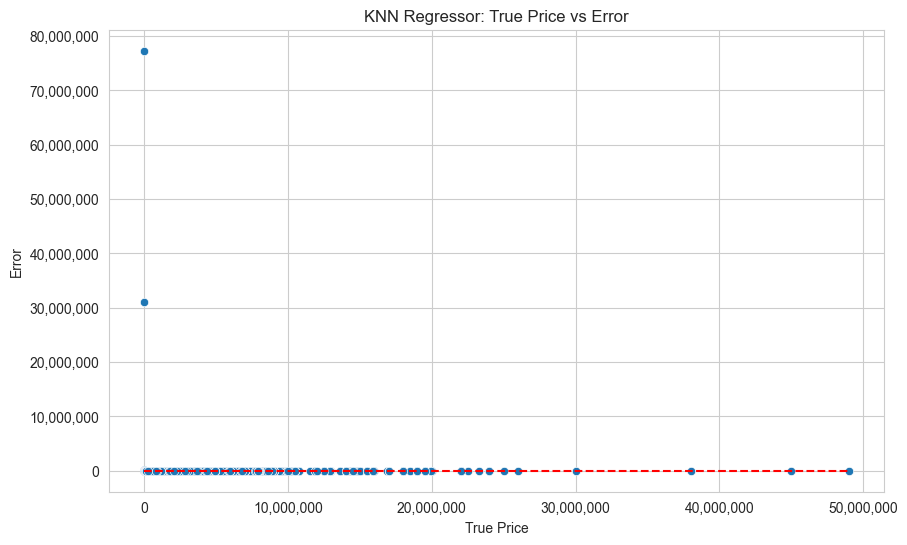

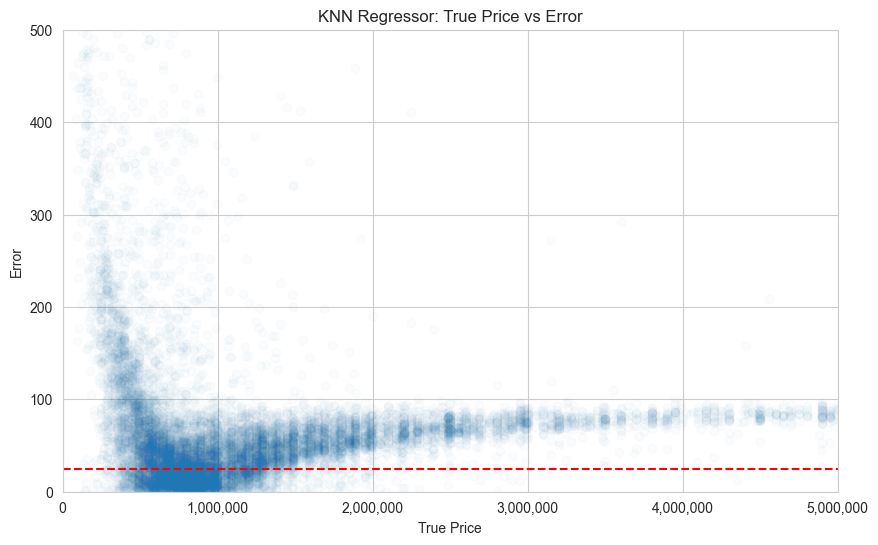

In [19]:
from src.utils.helperFunctions import analyse_highest_errors
import matplotlib.pyplot as plt
import seaborn as sns

y_pred = model.predict(X_train)
#y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))


y_pred = np.exp(y_pred)


mape = mean_absolute_percentage_error(y_train, y_pred) * 100
error_analysis = X_train.copy()
error_analysis = pd.DataFrame(scaler.inverse_transform(error_analysis), columns=X_train.columns)
error_analysis['predicted_price'] = y_pred
error_analysis['true_price'] = y_train
error_analysis['mape'] = np.abs(error_analysis['true_price'] - error_analysis['predicted_price']) / error_analysis['true_price'] * 100
error_analysis = error_analysis.sort_values(by='mape', ascending=False)
# Plot price vs error
import matplotlib.ticker as ticker

plt.figure(figsize=(10, 6))
sns.scatterplot(x=error_analysis['true_price'], y=error_analysis['mape'])
plt.xlabel('True Price')
plt.ylabel('Error')
plt.gca().xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))  # Format x-axis
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))  # Format y-axis
plt.title('KNN Regressor: True Price vs Error')
plt.hlines(y=mape, xmin=0, xmax=error_analysis['true_price'].max(), color='red',
           linestyles='dashed')
plt.show()
plt.figure(figsize=(10, 6))
plt.scatter(x=error_analysis['true_price'], y=error_analysis['mape'], alpha=0.02)
plt.xlabel('True Price')
plt.ylabel('Error')
plt.gca().xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))  # Format x-axis
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))  # Format y-axis
plt.ylim(0, 500)
plt.xlim(0, 5000000)
plt.title('KNN Regressor: True Price vs Error')

plt.hlines(y=mape, xmin=0, xmax=error_analysis['true_price'].max(), color='red',
           linestyles='dashed')
plt.show()

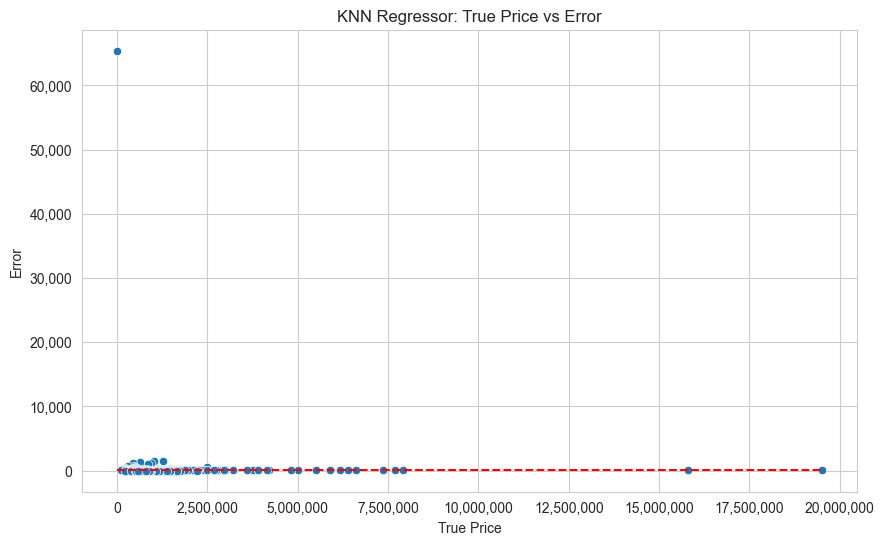

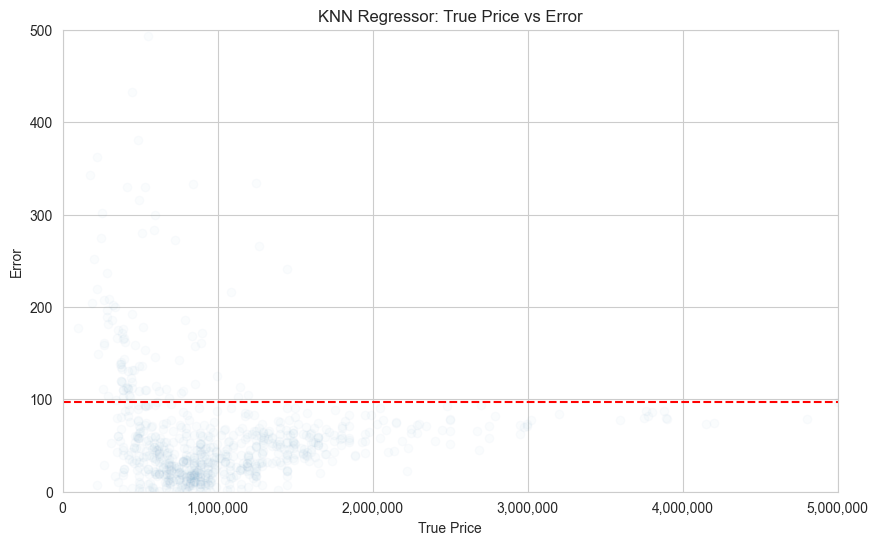

In [20]:
from src.utils.helperFunctions import analyse_highest_errors
import matplotlib.pyplot as plt
import seaborn as sns

y_pred = model.predict(X_test)
#y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))


y_pred = np.exp(y_pred)


mape = mean_absolute_percentage_error(y_test, y_pred) * 100
error_analysis = X_test.copy()
error_analysis = pd.DataFrame(scaler.inverse_transform(error_analysis), columns=X_test.columns)
error_analysis['predicted_price'] = y_pred
error_analysis['true_price'] = y_test
error_analysis['mape'] = np.abs(error_analysis['true_price'] - error_analysis['predicted_price']) / error_analysis['true_price'] * 100
error_analysis = error_analysis.sort_values(by='mape', ascending=False)
# Plot price vs error
import matplotlib.ticker as ticker

plt.figure(figsize=(10, 6))
sns.scatterplot(x=error_analysis['true_price'], y=error_analysis['mape'])
plt.xlabel('True Price')
plt.ylabel('Error')
plt.gca().xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))  # Format x-axis
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))  # Format y-axis
plt.title('KNN Regressor: True Price vs Error')
plt.hlines(y=mape, xmin=0, xmax=error_analysis['true_price'].max(), color='red',
           linestyles='dashed')
plt.show()
plt.figure(figsize=(10, 6))
plt.scatter(x=error_analysis['true_price'], y=error_analysis['mape'], alpha=0.02)
plt.xlabel('True Price')
plt.ylabel('Error')
plt.gca().xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))  # Format x-axis
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))  # Format y-axis
plt.ylim(0, 500)
plt.xlim(0, 5000000)
plt.title('KNN Regressor: True Price vs Error')

plt.hlines(y=mape, xmin=0, xmax=error_analysis['true_price'].max(), color='red',
           linestyles='dashed')
plt.show()

In [20]:
error_analysis

,ForestDensityL,ForestDensityM,ForestDensityS,NoisePollutionRoadL,NoisePollutionRoadM,NoisePollutionRoadS,RiversAndLakesL,RiversAndLakesM,RiversAndLakesS,distanceToTrainStation,...,region_group_13,region_group_14,region_group_15,region_group_16,region_group_17,region_group_18,region_group_19,predicted_price,true_price,mape
3614,0.014363,0.000000,0.000000,0.256548,0.191003,0.251588,0.000000,-1.734723e-18,0.000000,0.790824,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.325138e+05,1600.0,20682.111328
1391,0.153606,0.034261,0.003153,0.250197,0.289160,0.347215,0.000000,-1.734723e-18,0.000000,2.238216,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.288788e+06,360000.0,2202.440972
2229,0.284828,0.153670,0.113892,0.221735,0.278728,0.398407,0.055729,3.435720e-02,0.000000,0.530367,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.789011e+05,44000.0,1670.229830
2802,0.017014,0.001776,0.000000,0.368517,0.348719,0.258164,0.000000,-1.734723e-18,0.000000,1.679302,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.596026e+06,200000.0,1198.012875
2147,0.053443,0.001950,0.000000,0.238346,0.258137,0.330648,0.033664,1.024142e-02,0.000000,0.074428,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.469012e+05,80000.0,1083.626563
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4284,0.033094,0.026849,0.000000,0.444697,0.362273,0.238035,0.004479,-1.734723e-18,0.000000,0.223231,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.968048e+05,NaN,NaN
4286,0.511176,0.286451,0.090908,0.058298,0.067048,0.103850,0.082170,1.811382e-03,0.011871,3.038467,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,7.193361e+05,NaN,NaN
4287,0.024130,0.013442,0.000000,0.236504,0.271389,0.297746,0.049207,3.080823e-02,0.000000,0.178522,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,5.539024e+05,NaN,NaN
4288,0.093278,0.092806,0.031711,0.219788,0.235435,0.241742,0.000000,-1.734723e-18,0.000000,0.039087,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.411426e+06,NaN,NaN


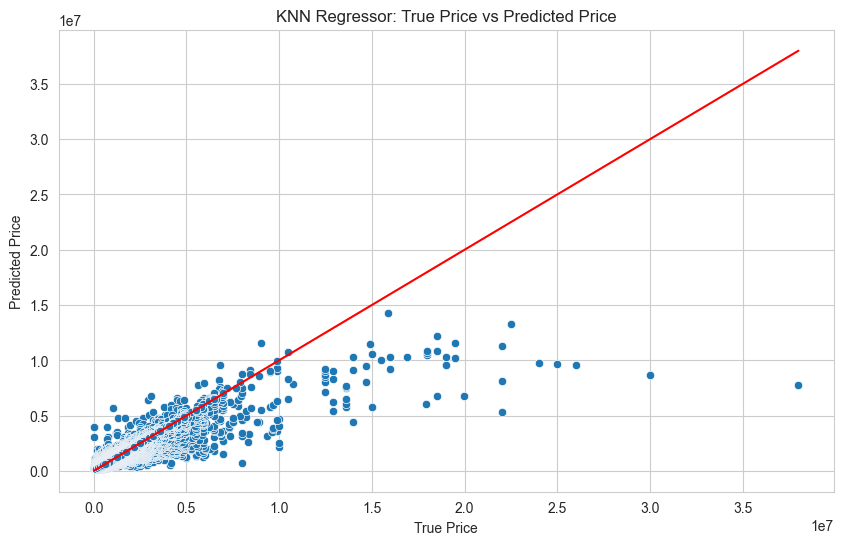

In [230]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=error_analysis['true_price'], y=error_analysis['predicted_price'])
sns.lineplot(x=error_analysis['true_price'], y=error_analysis['true_price'], color='red')
plt.xlabel('True Price')
plt.ylabel('Predicted Price')
plt.title('KNN Regressor: True Price vs Predicted Price')
plt.show()

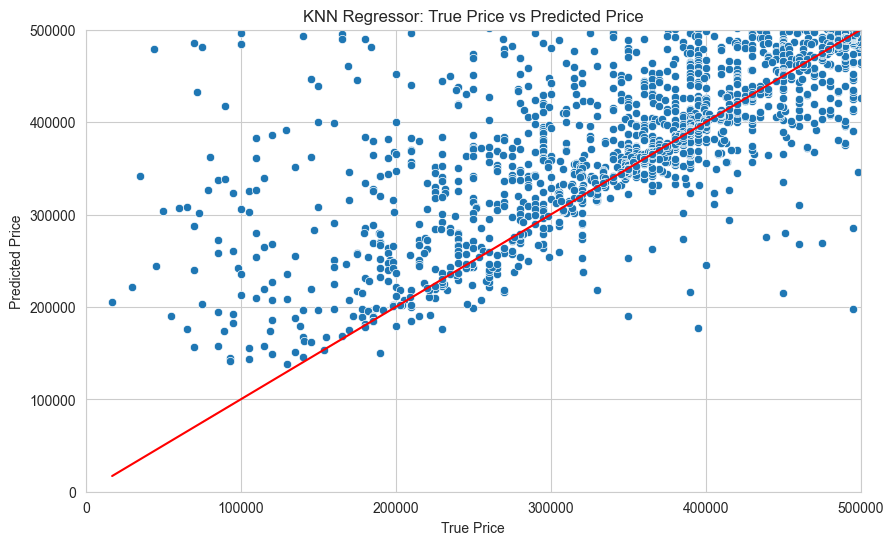

In [231]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=error_analysis['true_price'], y=error_analysis['predicted_price'])
sns.lineplot(x=error_analysis['true_price'], y=error_analysis['true_price'], color='red')
plt.xlabel('True Price')
plt.ylabel('Predicted Price')
plt.title('KNN Regressor: True Price vs Predicted Price')
plt.ylim(0, 500000)
plt.xlim(0, 500000)
plt.show()

# KNN

In [1]:
import os

import pandas as pd
import yaml

from src.dataPipeline import DataPipeline

os.chdir('..')

with open('src/params.yaml', 'r', encoding='utf-8') as file:
    params = yaml.safe_load(file)

columnsToDrop = params['columns_to_drop_all']

dp = DataPipeline()
dp.readCsv('data/immo_data_202208_v2.csv')

df = dp.data
feature_dummies = df['features'].str.get_dummies(sep='\t')
df = pd.concat([df, feature_dummies], axis=1)
df = df.drop(columns=['features'])

dp.data = df

dp.dropColumns(columnsToDrop)

df = dp.data

for column in df.columns:
    if column not in ['Availability', 'type', 'provider', 'type_unified', 'detailed_description']:
        try:
            df[column] = df[column].astype(float)
        except:
            print(f'Error in column: {column}')
            break

df['Availability'] = df['Availability'].apply(
    lambda x: 'Future' if len(str(x).split('.')) > 1 else x
)
dp.data = df

dp.encodeCategoricalFeatures()
dp.standardize()
df = dp.data
scaler = dp.scaler
df = df.dropna(subset=['price_cleaned'])
df = df[df['price_cleaned'] > 10000]

# Imputer
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=5, weights='distance')
df_imputed = imputer.fit_transform(df.copy())
df_imputed = pd.DataFrame(df_imputed, columns=df.columns)

C:\FHNW_Programmiersachen\5_Sem\immo_challenge\src\dataPipeline.py:46: DtypeWarning: Columns (3,4,5,6,11,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,45,46,47,49,50,107,110,114,115,116,119,120,121,124,125,126,128,131,132) have mixed types. Specify dtype option on import or set low_memory=False.
  self.data = pd.read_csv(filePath)


In [3]:
df_imputed

,ForestDensityL,ForestDensityM,ForestDensityS,NoisePollutionRailwayL,NoisePollutionRailwayM,NoisePollutionRailwayS,NoisePollutionRoadL,NoisePollutionRoadM,NoisePollutionRoadS,PopulationDensityL,...,type_unified_rustico,type_unified_secondary-suite,type_unified_semi-detached-house,type_unified_single-room,type_unified_stepped-apartment,type_unified_stepped-house,type_unified_studio,type_unified_terrace-house,type_unified_villa,provider_homegate.ch
0,1.612684,0.903235,0.072539,-0.511931,-0.385701,-0.244356,-1.431614,-1.551220,-1.257445,-0.587153,...,-0.055486,-0.00667,-0.200522,-0.011553,-0.098265,-0.053432,-0.065487,-0.156582,-0.243158,-0.826644
1,1.612684,0.903235,0.072539,-0.511931,-0.385701,-0.244356,-1.431614,-1.551220,-1.257445,-0.587153,...,-0.055486,-0.00667,-0.200522,-0.011553,-0.098265,-0.053432,-0.065487,6.386411,-0.243158,-0.826644
2,-0.124736,-0.157240,-0.470891,-0.511931,-0.385701,-0.244356,0.788090,0.955172,0.066983,1.076233,...,-0.055486,-0.00667,-0.200522,-0.011553,-0.098265,-0.053432,-0.065487,-0.156582,-0.243158,-0.826644
3,1.612684,0.903235,0.072539,-0.511931,-0.385701,-0.244356,-1.431614,-1.551220,-1.257445,-0.587153,...,-0.055486,-0.00667,-0.200522,-0.011553,-0.098265,-0.053432,-0.065487,-0.156582,-0.243158,-0.826644
4,0.726969,0.863309,0.407935,-0.511931,-0.385701,-0.244356,-0.828264,-1.025663,-0.354546,0.113062,...,-0.055486,-0.00667,-0.200522,-0.011553,-0.098265,-0.053432,-0.065487,-0.156582,-0.243158,-0.826644
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21439,1.535455,1.456550,0.111435,-0.511931,-0.385701,-0.244356,-0.001742,0.572635,0.800212,-0.450109,...,-0.055486,-0.00667,-0.200522,-0.011553,-0.098265,-0.053432,-0.065487,-0.156582,-0.243158,1.209711
21440,-0.940771,-0.690764,-0.482560,-0.511931,-0.385701,-0.244356,0.713096,0.983071,1.269908,1.127705,...,-0.055486,-0.00667,-0.200522,-0.011553,10.176581,-0.053432,-0.065487,-0.156582,-0.243158,1.209711
21441,-0.940771,-0.690764,-0.482560,1.539447,2.157461,0.459541,0.561866,0.402426,-0.260984,1.153635,...,-0.055486,-0.00667,-0.200522,-0.011553,-0.098265,-0.053432,-0.065487,-0.156582,-0.243158,1.209711
21442,1.111498,0.151517,-0.248385,-0.511931,-0.385701,-0.244356,-0.310220,0.062891,0.127784,-0.761983,...,-0.055486,-0.00667,-0.200522,-0.011553,10.176581,-0.053432,-0.065487,-0.156582,-0.243158,1.209711


In [ ]:
# Import necessary libraries
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_percentage_error

df = df_imputed

y = df['price_cleaned']
y_log = np.log(y)
#y_log = y

X = df.drop(columns=['price_cleaned'])


train_test_split_ratio = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=train_test_split_ratio)


# Initialize KNN Regressor
model = KNeighborsRegressor(n_neighbors=5, algorithm='kd_tree', weights='distance', p=10)  # Use 5 neighbors

# Train the model
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

y_test = np.exp(y_test)
y_pred = np.exp(y_pred)

mape = mean_absolute_percentage_error(y_test, y_pred) * 100

print(f'Test MAPE: {mape:.3f}%')

# Train Mape
y_pred = model.predict(X_train)
y_train = np.exp(y_train)
y_pred = np.exp(y_pred)

mape = mean_absolute_percentage_error(y_train, y_pred) * 100

print(f'Train MAPE: {mape:.3f}%')

Test MAPE: 42.948%
